In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [47]:
# Load dataset 
url = "https://raw.githubusercontent.com/MaharLeika18/Data-Mining---Python/refs/heads/main/Titanic-Dataset.csv"
data = pd.read_csv(url)

In [48]:
# Clean and preprocess the data
data = data.drop_duplicates()   # Drop dupes
data['Age'] = data['Age'].fillna(data['Age'].median())  # Fill missing cells in Age w/ median
data['Fare'] = data['Fare'].fillna(data['Fare'].median()) # Same but in Fare
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0]) # Same but in Embarked and fill w/ mode
data["Fare"] = data["Fare"].round(0)    # Round Fare to nearest integer
data["Age"] = data["Age"].round(0)      # Same for Age

# Drop columns that won't be used
data = data.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis=1)

# Create new columns for:
data['Family'] = data['SibSp'] + data['Parch'] + 1  # Total family members on board
data['IsAlone'] = (data['Family'] == 1).astype(int) # Whether they are travelling alone or not

# Convert text values into measurable numerical values
data['Sex'] = data['Sex'].map({'male':0, 'female':1})   # Male = 0, Female = 1
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2}) # S = 0, C = 1, Q = 2

data['Survived'] = data['Survived'].astype('category')


In [49]:
# Preview the cleaned data, see what columns can be used for analysis
print(data.describe()) # Summary
data.sample(10)  # Random 5 rows


           Pclass         Sex         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     2.308642    0.352413   29.356902    0.523008    0.381594   32.214366   
std      0.836071    0.477990   13.017814    1.102743    0.806057   49.693352   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000   22.000000    0.000000    0.000000    8.000000   
50%      3.000000    0.000000   28.000000    0.000000    0.000000   14.000000   
75%      3.000000    1.000000   35.000000    1.000000    0.000000   31.000000   
max      3.000000    1.000000   80.000000    8.000000    6.000000  512.000000   

         Embarked      Family     IsAlone  
count  891.000000  891.000000  891.000000  
mean     0.361392    1.904602    0.602694  
std      0.635673    1.613459    0.489615  
min      0.000000    1.000000    0.000000  
25%      0.000000    1.000000    0.000000  
50%   

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,IsAlone
535,1,2,1,7.0,0,2,26.0,0,3,0
827,1,2,0,1.0,0,2,37.0,1,3,0
855,1,3,1,18.0,0,1,9.0,0,2,0
659,0,1,0,58.0,0,2,113.0,1,3,0
353,0,3,0,25.0,1,0,18.0,0,2,0
82,1,3,1,28.0,0,0,8.0,2,1,1
723,0,2,0,50.0,0,0,13.0,0,1,1
428,0,3,0,28.0,0,0,8.0,2,1,1
266,0,3,0,16.0,4,1,40.0,0,6,0
299,1,1,1,50.0,0,1,248.0,1,2,0


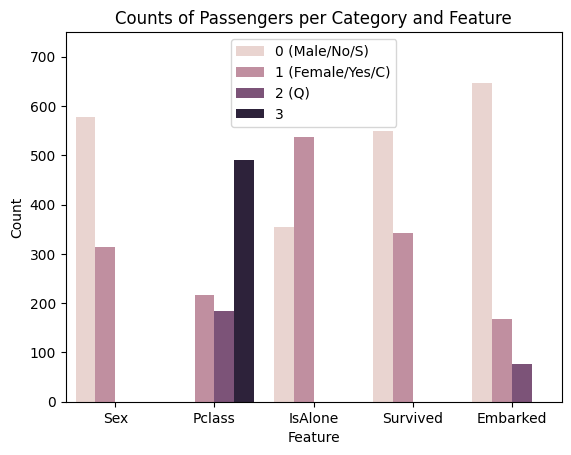

In [50]:
# Display the count of categories across multiple columns - Bar chart
categories = ["Sex", "Pclass", "IsAlone", "Survived", "Embarked"]
converted = data[categories].melt(var_name="Feature", value_name="Category")  # Convert the columns into rows

sns.countplot(data=converted, x="Feature", hue="Category")
plt.title("Counts of Passengers per Category and Feature")
plt.ylabel("Count")
plt.xlabel("Feature")
plt.ylim(top=750)
plt.legend(["0 (Male/No/S)", "1 (Female/Yes/C)", "2 (Q)", "3"])

plt.show()



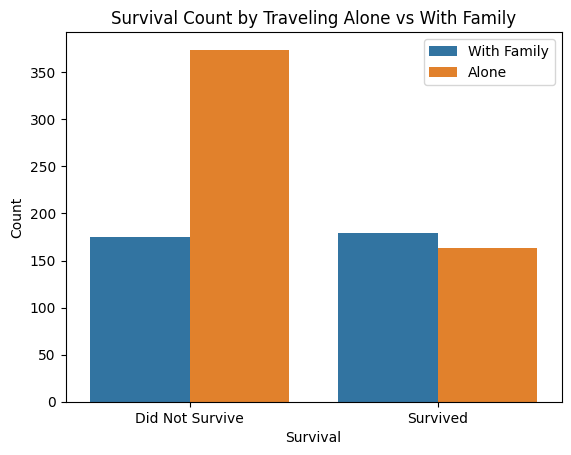

In [51]:
# Compare survival rate of passengers based on whether they travelled alone or not - Bar
sns.countplot(x="Survived", hue="IsAlone",data=data)

plt.title("Survival Count by Traveling Alone vs With Family")
plt.xlabel("Survival")
plt.ylabel("Count")
plt.xticks([0, 1], ["Did Not Survive", "Survived"])
plt.legend(["With Family", "Alone"])

plt.show()

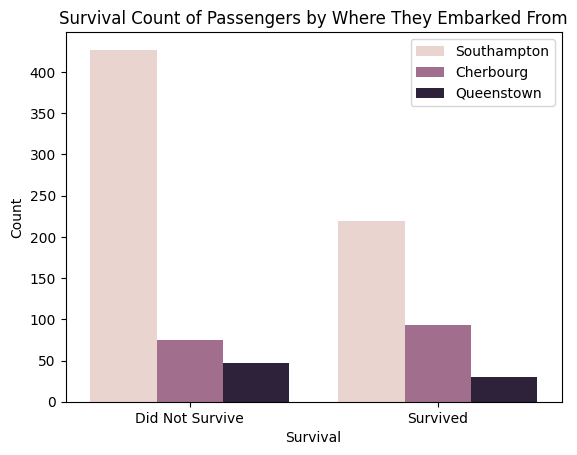

In [52]:
# Compare survival rate of passengers based on where they embarked from - Bar
sns.countplot(x="Survived", hue="Embarked",data=data)

plt.title("Survival Count of Passengers by Where They Embarked From")
plt.xlabel("Survival")
plt.ylabel("Count")
plt.xticks([0, 1], ["Did Not Survive", "Survived"])
plt.legend(["Southampton", "Cherbourg", "Queenstown"])

plt.show()


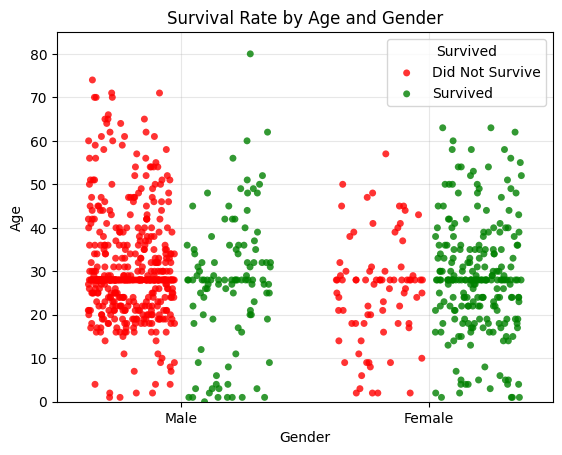

In [53]:
# Display the survival rate of passengers based on their age and gender - Scatter 
sns.stripplot(
    x='Sex',
    y='Age',
    data=data,
    hue='Survived',
    palette={0: 'red', 1: 'green'},
    jitter=0.35,
    alpha=0.8,
    dodge=True
)

plt.title("Survival Rate by Age and Gender")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.xticks([0, 1], ["Male", "Female"])
plt.legend(title="Survived", labels=["Did Not Survive", "Survived"])
plt.grid(True, alpha=0.3)
plt.ylim(0, 85)
plt.show()

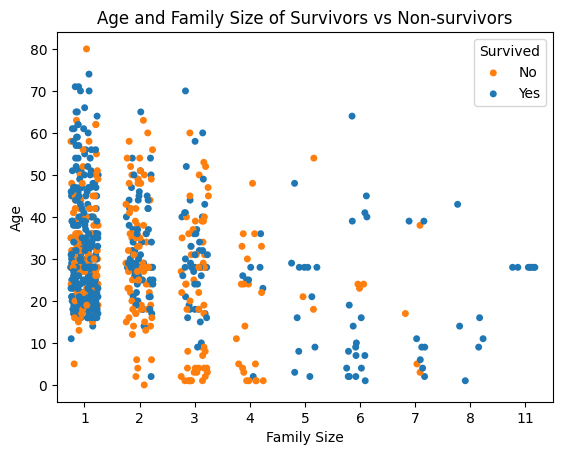

In [54]:
# Compare age and family sizes of passengers that survived and those that didn't - Scatterplot
sns.stripplot(x="Family", y="Age", data=data, hue="Survived", jitter=0.25)

plt.title("Age and Family Size of Survivors vs Non-survivors")
plt.xlabel("Family Size")
plt.ylabel("Age")
plt.legend(title="Survived",labels=["No", "Yes"])

plt.show()

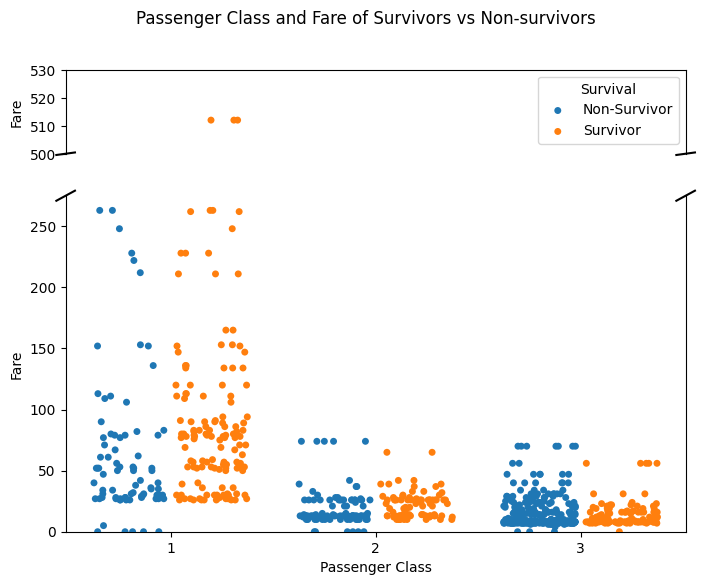

In [55]:
# Compare survival rate of passengers based on passenger class and fare - Scatter
lowerHalf = (0, 275)
upperHalf = (500, 530)

fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios':[1,4]}
)

sns.stripplot(x="Pclass", y="Fare", hue="Survived", data=data, ax=ax1, jitter=0.35, dodge=True)
sns.stripplot(x="Pclass", y="Fare", hue="Survived", data=data, ax=ax2, legend=False, jitter=0.35, dodge=True)

ax1.set_ylim(upperHalf)
ax2.set_ylim(lowerHalf)

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', labelbottom=False)

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d,+d), (-d,+d), **kwargs)        
ax1.plot((1-d,1+d), (-d,+d), **kwargs)     

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d,+d), (1-d,1+d), **kwargs)     
ax2.plot((1-d,1+d), (1-d,1+d), **kwargs)   

ax2.set_xlabel("Passenger Class")
ax1.set_ylabel("Fare")
ax2.set_ylabel("Fare")
ax1.legend(title="Survival", labels=["Non-Survivor", "Survivor"])
plt.suptitle("Passenger Class and Fare of Survivors vs Non-survivors")

plt.show()

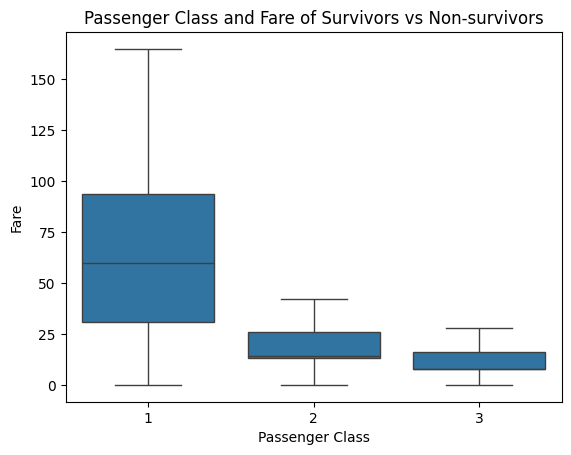

In [56]:
# Boxplot Version
sns.boxplot(x="Pclass", y="Fare", data=data, showfliers=False)

plt.title("Passenger Class and Fare of Survivors vs Non-survivors")
plt.xlabel("Passenger Class")
plt.ylabel("Fare")

plt.show()


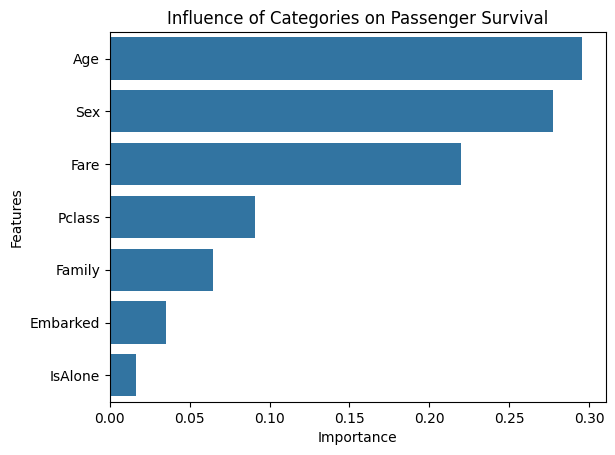

In [57]:
# Influence of certain categories on survival
x = data[["Sex", "Age", "Pclass", "Family", "IsAlone", "Embarked", "Fare"]]
y = data["Survived"]

tree = RandomForestClassifier(random_state=42)
tree.fit(x, y)

importances = tree.feature_importances_
feat_importances = pd.DataFrame({
    "Feature": x.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

sns.barplot(data=feat_importances, x="Importance", y="Feature")

plt.title("Influence of Categories on Passenger Survival")
plt.xlabel("Importance")
plt.ylabel("Features")

plt.show()

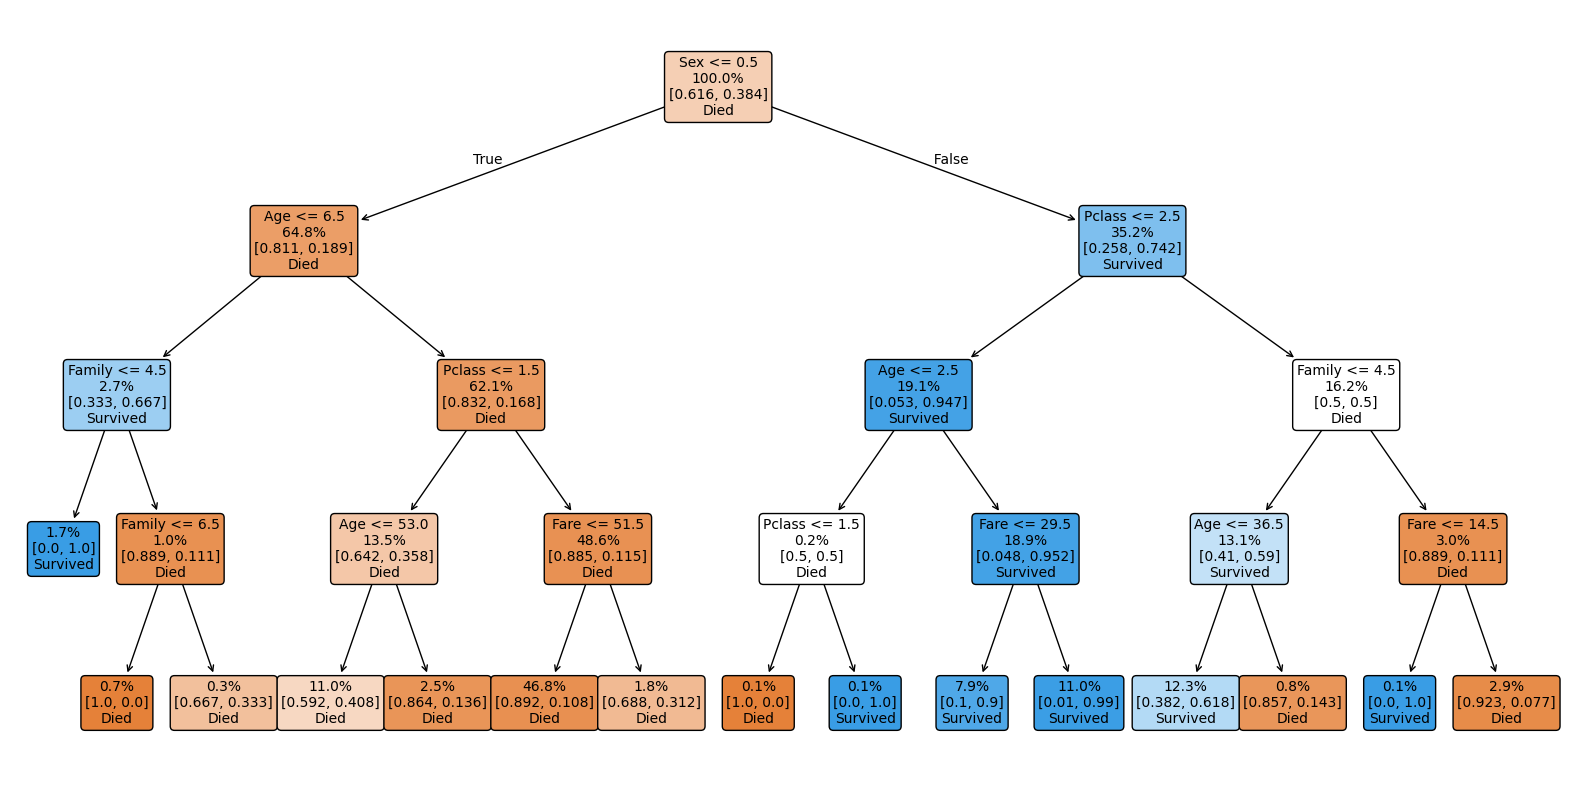

In [65]:
# Decision Tree (For future use, ignore)
features = ["Sex", "Family", "IsAlone", "Fare", "Embarked", "Age", "Pclass"]

x = data[features]
y = data["Survived"]

dtree = DecisionTreeClassifier(max_depth=4, random_state=42)
dtree = dtree.fit(x, y)

plt.figure(figsize=(20, 10))
plot_tree(
    dtree, feature_names=features, class_names=["Died", "Survived"], filled=True, rounded=True, fontsize=10,
    impurity=False, label="none", proportion=True
) 

plt.show()